## Imports

In [1]:
# Preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
import warnings
import json
import os

# Models
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from itertools import product

# Plotting
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## File Reading

In [2]:
file_name = 'XY_train.csv'
current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'XY_train.csv')

## Pre-Process

In [3]:
def fill_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Input: a dataframe that contains missing values
    Returns: a dataframe that doesn't contain any missing values using knn imputation
    """

    columns_with_missing_values = df.columns[df.isnull().any()].tolist()
    imputer = KNNImputer(n_neighbors = 5)
    df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])
    return df

def fix_irrational_driving_age(df: pd.DataFrame) -> pd.DataFrame:
    """
    Input: a dataframe that contains the driving age column with irrational values
    Returns: a dataframe with the driving age column fixed with minimum value of 16
    """
    df['LICENSE_AGE'] = df['AGE'] - df['DRIVING_EXPERIENCE']
    df['DRIVING_EXPERIENCE'] = np.where(df['LICENSE_AGE'] < 16, df['AGE'] - 16, df['DRIVING_EXPERIENCE'])
    df['LICENSE_AGE'] = df['AGE'] - df['DRIVING_EXPERIENCE'] # update the license age
    return df.drop(columns = ['LICENSE_AGE'])

def get_categorial_mapping(df: pd.DataFrame, categorical_columns: pd.DataFrame):
    """
    Input: categorial columns and the dataframe itself
    Returns: a dictionary that contains the mapping of the categorial values to integers
    """
    indexed_mappings = {}
    for col in categorical_columns.columns:
        unique_values = df[col].unique()
        mapping = {value: idx for idx, value in enumerate(unique_values)}
        indexed_mappings[col] = mapping
    return indexed_mappings

def kbin_normal_distribution(column: pd.Series, n_bins: int = 3):
    """
    Input: a column that contains continous numerical values
    Returns: a column that contains the binned values of the input column
    """
    if column.nunique() == 1:
        return pd.Series([0] * len(column), index=column.index)

    column_reshaped = column.values.reshape(-1, 1)
    n_bins = min(n_bins, column.nunique())

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*Feature 0 is constant.*")
        warnings.filterwarnings("ignore", message=".*Bins whose width are too small.*")
        kbin = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
        binned_column = kbin.fit_transform(column_reshaped).astype(int)
    return pd.Series(binned_column.flatten(), index=column.index)

def kbin_exp_distribution(column: pd.Series, n_bins: int = 3):
    """
    Input: a column that contains continous numerical values but with exponential distribution
    Returns: a column that contains the binned values of the input column
    """
    if column.nunique() == 1:
        return pd.Series([0] * len(column), index=column.index)

    if column.min() <= 0:
        column = column + abs(column.min()) + 1

    log_column = np.log(column)
    column_reshaped = log_column.values.reshape(-1, 1)
    n_bins = min(n_bins, column.nunique())

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*Feature 0 is constant.*")
        warnings.filterwarnings("ignore", message=".*Bins whose width are too small.*")
        kbin = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
        binned_column = kbin.fit_transform(column_reshaped).astype(int)
    return pd.Series(binned_column.flatten(), index=column.index)

def categorize_age_attribute(age: int):
    """
    Input: age in the form of integer
    Returns: a string that represents the age category
    Logic:
    Age will be categorized as weight, so the very young and very old people will be considered as high risk
    """
    if age <= 24: return 3 
    elif age <= 65: return 1
    return 2

def categorize_driving_experience(years: int):
    """
    Input: years of driving experience in the form of integer
    Returns: a string that represents the driving experience category
    Logic:
    The less experience the driver has, the more risk he/she will be
    """
    if years <= 2: return 3
    elif years <= 8: return 2
    return 1

def categorize_risk_index(risk_index: float):
    """
    Input: risk index in the form of float
    Returns: a string that represents the risk index category
    """
    if risk_index <= 4: return 1
    elif risk_index <= 6: return 2
    return 3

def categorize_attributes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Input: a dataframe that contains the raw data but proccessed
    Returns: a dataframe that contains the categorial columns mapped and the numerical columns binned
    """
    categorical_columns = df.select_dtypes(exclude=['float64', 'int64'])
    categorial_mapping = get_categorial_mapping(df, categorical_columns)
    for col, mapping in categorial_mapping.items(): # assign the mapping to the categorial columns
        df[col] = df[col].map(mapping)

    df['CREDIT_SCORE'] = kbin_normal_distribution(df['CREDIT_SCORE'])
    df['MILEAGE_EXPERIANCE_RATIO'] = df['ANNUAL_MILEAGE'] / (1 + df['DRIVING_EXPERIENCE'])
    df['MILEAGE_EXPERIANCE_RATIO'] = kbin_exp_distribution(df['MILEAGE_EXPERIANCE_RATIO'])
    df['ANNUAL_MILEAGE'] = kbin_normal_distribution(df['ANNUAL_MILEAGE'])
    df['AGE'] = df['AGE'].apply(categorize_age_attribute)
    df['EXPERIENCE_QUALITY'] = df['DRIVING_EXPERIENCE'] / (1 + df['PAST_ACCIDENTS'])
    df['EXPERIENCE_QUALITY'] = kbin_exp_distribution(df['EXPERIENCE_QUALITY'])
    df['DRIVING_EXPERIENCE'] = df['DRIVING_EXPERIENCE'].apply(categorize_driving_experience)
    df['DRIVER_RISK_INDEX'] = 0.4 * df['SPEEDING_VIOLATIONS'] + 0.4 * df['PAST_ACCIDENTS'] + 0.2 * df['DRIVING_EXPERIENCE'] * df['AGE']
    df['DRIVER_RISK_INDEX'] = df['DRIVER_RISK_INDEX'].apply(categorize_risk_index)
    df['SPEEDING_VIOLATIONS'] = kbin_exp_distribution(df['SPEEDING_VIOLATIONS'])
    df['PAST_ACCIDENTS'] = kbin_exp_distribution(df['PAST_ACCIDENTS'])
    return df

def pre_process(raw: pd.DataFrame) -> pd.DataFrame:
    """
    Input: a dataframe that contains the raw data
    Returns: a dataframe that has been pre-processed using the logic below
    """
    df = fill_missing_values(raw)
    df = fix_irrational_driving_age(df)
    df = categorize_attributes(df)
    return df

## Split Test-Train

In [4]:
def split_train_test(df: pd.DataFrame, ratio: float):
    """
    Input: a dataframe that has been pre-processed and a ratio for the train and test set
    Returns: train and test sets
    """
    train = df.sample(frac = ratio)
    test = df.drop(train.index)
    return train, test

## Common Functions

In [5]:
def standardize_data(data: pd.DataFrame):
    minmax_scaler = MinMaxScaler()
    x = data.drop(columns=['OUTCOME'])
    y = data['OUTCOME']
    x_scaled = minmax_scaler.fit_transform(x)
    return x_scaled, y

def plot_confusion_matrix(y_test: pd.Series, y_pred: np.ndarray, labels=None):
    """
    Plots the confusion matrix.
    """
    cm = confusion_matrix(y_test, y_pred)
    unique_labels = labels if labels else np.unique(y_test)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(cm.shape[1]), labels=unique_labels, rotation=45)
    plt.yticks(np.arange(cm.shape[0]), labels=unique_labels)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="black")
    plt.show()
    

## Decision Tree

In [6]:
def build_tree(df: pd.DataFrame, depth: int = None, criterion: str = 'gini', splitter: str = 'best'):
    """
    Input: a dataframe that has been pre-processed and contains the train set
    Returns: a decision tree that has been trained on the given set
    """
    return DecisionTreeClassifier(max_depth=depth, criterion=criterion, splitter=splitter).fit(df.drop(columns = ['OUTCOME']), df['OUTCOME'])

def visualize_tree(tree, feature_names, pdf_path="decision_tree.pdf"):
    """
    Input:
      - tree: The trained decision tree model
      - feature_names: List of feature names used in the training data
    Outputs:
      - A PDF file with a simplified and more readable visualization of the decision tree.
    """
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(30, 20))  # Increase figure size for larger bricks
        plot_tree(
            tree,
            feature_names=feature_names,  # Use feature names for splits
            class_names=['0', '1'],       # Use '0' and '1' for classes
            filled=True,                  # Add colors
            rounded=True,                 # Rounded nodes
            fontsize=7                   # Set font size for better readability
        )
        plt.title("Decision Tree Visualization", fontsize=20)  # Larger title
        pdf.savefig()  # Save the current figure to the PDF
        plt.close()
    print(f"Decision tree saved to {pdf_path}")

def get_maximum_accuracy_ratio(df: pd.DataFrame):
    """
    Input: a dataframe that has been pre-processed
    Returns: the maximum accuracy ratio of the decision tree
    """
    accuracy_map = []
    for i in range(10):
        for ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            train, test = split_train_test(df, ratio=ratio)
            tree = build_tree(train)
            accuracy = tree.score(test.drop(columns=['OUTCOME']), test['OUTCOME'])
            accuracy_map.append({'Iteration': i, 'Ratio': ratio, 'Accuracy': accuracy, 'Tree': tree})
    accuracy_df = pd.DataFrame(accuracy_map)
    accuracy_summary = accuracy_df.groupby('Ratio').agg({'Accuracy': 'mean'}).reset_index()
    best_ratio_row = accuracy_summary[accuracy_summary['Accuracy'] == accuracy_summary['Accuracy'].max()]
    return best_ratio_row['Ratio'].values[0]

def grid_search_tree(df: pd.DataFrame, max_depth_range: range, criteria: list, splitters: list, ratio: float):
    """
    Input:
        - df: Pre-processed DataFrame
        - max_depth_range: Range of max depths to test
        - criteria: List of criteria to test (e.g., ['gini', 'entropy', 'log_loss'])
        - splitters: List of splitters to test (e.g., ['best', 'random'])
        - ratio: Train-test split ratio
    Returns:
        - A DataFrame with grid search results
    """
    results = []
    train, test = split_train_test(df, ratio=ratio)

    for criterion in criteria:
        for splitter in splitters:
            for depth in max_depth_range:
                tree = build_tree(train, depth=depth, criterion=criterion, splitter=splitter)
                accuracy = tree.score(test.drop(columns=['OUTCOME']), test['OUTCOME'])
                results.append({
                    'Criterion': criterion,
                    'Splitter': splitter,
                    'Max Depth': depth,
                    'Accuracy': accuracy
                })
    
    return pd.DataFrame(results)

def plot_heatmaps(results: pd.DataFrame):
    """
    Input: Results DataFrame from grid search
    Displays: Heatmaps for Accuracy with Splitter as separate heatmaps
    """
    splitters = results['Splitter'].unique()  # Get unique splitters
    for splitter in splitters:
        splitter_data = results[results['Splitter'] == splitter]
        heatmap_data = splitter_data.pivot(index='Criterion', columns='Max Depth', values='Accuracy')
        
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='YlGnBu', cbar=True)
        plt.title(f"Heatmap of Grid Search Results for Splitter = {splitter}")
        plt.xlabel('Max Depth')
        plt.ylabel('Criterion')
        plt.show()

def find_best_combination(results: pd.DataFrame):
    """
    Input: Results DataFrame from grid search
    Returns: The best combination of max_depth, criterion, and splitter with the highest accuracy
    """
    best_row = results.loc[results['Accuracy'].idxmax()]
    return best_row

def plot_3d_results(results: pd.DataFrame):
    """
    Input: Results DataFrame from grid search
    Displays: An interactive 3D scatter plot of Accuracy with Criterion, Splitter, and Max Depth
    """
    fig = px.scatter_3d(
        results,
        x='Max Depth',      # X-axis
        y='Criterion',      # Y-axis
        z='Accuracy',       # Z-axis
        color='Splitter',   # Color by splitter
        symbol='Splitter',  # Different symbols for splitters
        size='Accuracy',    # Size based on accuracy
        title="3D Visualization of Grid Search Results",
        labels={
            'Max Depth': 'Max Depth',
            'Criterion': 'Criterion',
            'Accuracy': 'Accuracy',
            'Splitter': 'Splitter'
        }
    )
    fig.update_traces(marker=dict(size=8, opacity=0.8))
    fig.update_layout(scene=dict(
        xaxis_title='Max Depth',
        yaxis_title='Criterion',
        zaxis_title='Accuracy'
    ))
    fig.show()

def get_decision_tree(df: pd.DataFrame, params: dict = False):
    """
    Input: a dataframe that has been pre-processed
    Returns: the decision tree with the highest accuracy

    Logic:
    1. Split the data into train and test sets
    2. Build a decision tree using the train set
    3. Evaluate the accuracy of the decision tree on the test set
    4. Repeat the process for 10 iterations
    5. Find the best ratio of the train and test set in terms of tree accuracy
    6. Find the best combination of the decision tree hyperparameters
    7. Return the best decision tree
    """
    # ratio = get_maximum_accuracy_ratio(df)
    # max_depth_range = range(1, 20)
    # criteria = ['gini', 'entropy', 'log_loss']
    # splitters = ['best', 'random']
    # results = grid_search_tree(df, max_depth_range, criteria, splitters, ratio)
    # best_combination = find_best_combination(results)
    # print(f"The best combination is:\n{best_combination}")
    # plot_heatmaps(results)
    # plot_3d_results(results)
    if params:
        return build_tree(df, **params)
    return build_tree(df)

def get_results_per_tree(decision_tree, train, test):
    X_train = train.drop(columns=['OUTCOME'])
    y_train = train['OUTCOME']
    X_test = test.drop(columns=['OUTCOME'])
    y_test = test['OUTCOME']

    train_predictions = decision_tree.predict(X_train)
    test_predictions = decision_tree.predict(X_test)
    train_f1 = f1_score(y_train, train_predictions)
    test_f1 = f1_score(y_test, test_predictions) 

    print(f"The F1 score of the decision tree on the train set is: {train_f1}")
    print(f"The F1 score of the decision tree on the test set is: {test_f1}")
    feature_importance = decision_tree.feature_importances_
    feature_names = train.drop(columns=['OUTCOME']).columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    print(feature_importance_df)
    # visualize_tree(decision_tree, train.drop(columns=['OUTCOME']).columns)

def decision_tree_section(train: pd.DataFrame, test: pd.DataFrame):
    """
    Gathers the decision tree section of the code
    """
    params = {
        'depth': 8,
        'criterion': 'entropy',
        'splitter': 'best'
    }
    base_decision_tree = get_decision_tree(train)
    modified_decision_tree = get_decision_tree(train, params)
    # print("Base Decision Tree")
    # get_results_per_tree(base_decision_tree, train, test)
    # print("\nModified Decision Tree")
    # get_results_per_tree(modified_decision_tree, train, test)

    return modified_decision_tree #, base_decision_tree

## Neural Network

In [7]:
def nn_model_with_modified_params(x_train_scaled: pd.DataFrame, y_train: pd.Series, params: dict):
    """
    Trains the NN model with modified params and returns the best model and its parameters.
    """
    model = MLPClassifier()
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='accuracy')
    grid_search.fit(x_train_scaled, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

def check_nn_model_accuracy(nn_model: MLPClassifier, x: pd.DataFrame, y: pd.Series):
    """
    Prints the accuracy of the NN model on the train and test sets.
    """
    nn_model.fit(x, y)
    y_pred = nn_model.predict(x)
    f1_accuracy = f1_score(y, y_pred, average="weighted")
    return f1_accuracy

def build_nn_model(x_train_scaled: pd.DataFrame, y_train: pd.Series = None, params: dict = None):
    """
    Input: train set to train NN model, params that can be used to modify the model
    Returns: NN model with the given params
    """
    if not params:
        return MLPClassifier()
    return nn_model_with_modified_params(x_train_scaled, y_train, params)

def plot_nn_heatmap(param_grid: dict, x_train_scaled: pd.DataFrame, y_train: pd.Series, x_test_scaled: pd.DataFrame, y_test: pd.Series):
    """
    Generates heatmaps to visualize NN model accuracy for different parameter combinations.
    """
    param_combinations = list(product(
        param_grid['hidden_layer_sizes'], 
        param_grid['activation'], 
        param_grid['alpha'], 
        param_grid['max_iter']
    ))

    results = []
    for params in param_combinations:
        hidden_layer_sizes, activation, alpha, max_iter = params
        model = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            alpha=alpha,
            max_iter=max_iter,
            random_state=42
        )
        model.fit(x_train_scaled, y_train)
        accuracy = model.score(x_test_scaled, y_test)
        results.append({
            'hidden_layer_sizes': hidden_layer_sizes,
            'activation': activation,
            'alpha': alpha,
            'max_iter': max_iter,
            'accuracy': accuracy
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    heatmap_plots = [
        {
            "pivot_index": "activation",
            "pivot_columns": "hidden_layer_sizes",
            "title": "Activation vs Hidden Layer Sizes (Fixed Alpha)",
            "constant_param": "alpha"
        },
        {
            "pivot_index": "alpha",
            "pivot_columns": "hidden_layer_sizes",
            "title": "Alpha vs Hidden Layer Sizes (Fixed Activation)",
            "constant_param": "activation"
        },
        {
            "pivot_index": "alpha",
            "pivot_columns": "activation",
            "title": "Alpha vs Activation (Fixed Hidden Layer Sizes)",
            "constant_param": "hidden_layer_sizes"
        }
    ]

    for plot_config in heatmap_plots:
        constant_param = plot_config["constant_param"]
        unique_constants = results_df[constant_param].unique()

        for constant_value in unique_constants:
            filtered_df = results_df[results_df[constant_param] == constant_value]
            heatmap_data = filtered_df.pivot_table(
                index=plot_config["pivot_index"],
                columns=plot_config["pivot_columns"],
                values="accuracy",
                aggfunc="mean"
            )

            plt.figure(figsize=(10, 6))
            sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f", cbar=True)
            plt.title(f"{plot_config['title']} ({constant_param}={constant_value})")
            plt.xlabel(plot_config["pivot_columns"])
            plt.ylabel(plot_config["pivot_index"])
            plt.show()

def print_model_details(model: MLPClassifier, x, y, params: dict = None):
    if params:
        print(f"Model Details with the following parameters:\n{json.dumps(params, indent=4)}")
        train_f1 = check_nn_model_accuracy(model, x, y)
        test_f1 = check_nn_model_accuracy(model, x, y)
        print(f"Modifed Model F1 Score for train data: {train_f1 * 100:.2f}%")
        print(f"Modifed Model F1 Score for test data: {test_f1 * 100:.2f}%")
    else:
        base_train_f1 = check_nn_model_accuracy(model, x, y)
        base_test_f1 = check_nn_model_accuracy(model, x, y)
        print(f"Base Model F1 Score for train data: {base_train_f1 * 100:.2f}%\n")
        print(f"Base Model F1 Score for test data: {base_test_f1 * 100:.2f}%\n")

def neural_network_section(train: pd.DataFrame, test: pd.DataFrame):
    """
    Gathers the neural network section of the code
    """
    x_train_scaled, y_train = standardize_data(train) # = minmax_scaler.fit_transform(x_train)
    x_test_scaled, y_test = standardize_data(test) # = minmax_scaler.transform(x_test)

    params = {
        'hidden_layer_sizes': [(50, 50), (50, 50, 50), (100, 100), (100, 100, 100)],
        'activation': ['relu', 'identity', 'logistic', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'adaptive', 'invscaling'],
        'max_iter': [200, 400]
    }

    # Base Model
    default_model = build_nn_model(x_train_scaled, y_train)
    # print_model_details(default_model, x_train_scaled, y_train)
    # print_model_details(default_model, x_test_scaled, y_test)

    # Modified Model
    best_hyper_model, best_params = build_nn_model(x_train_scaled, y_train, params)
    # print_model_details(best_hyper_model, x_train_scaled, y_train, best_params)
    # print_model_details(best_hyper_model, x_test_scaled, y_test, best_params)

    # plot_nn_heatmap(params, x_train_scaled, y_train, x_test_scaled, y_test)
    return default_model #, best_hyper_model

## Clustering

In [8]:
def relabel_clusters(kmeans_clusters: np.ndarray, y_train: pd.Series):
    """
    Relabels clusters to align with the actual labels using majority voting.
    """
    mapping = {}
    for cluster in np.unique(kmeans_clusters):
        # Find the majority class in each cluster
        cluster_indices = np.where(kmeans_clusters == cluster)[0]
        majority_class = y_train.iloc[cluster_indices].mode()[0]
        mapping[cluster] = majority_class
    
    # Map the clusters to the majority class labels
    relabeled_clusters = np.array([mapping[cluster] for cluster in kmeans_clusters])
    return relabeled_clusters

def calculate_accuracy(y_train: pd.Series, relabeled_clusters: np.ndarray):
    """
    Calculates the percentage of correctly clustered records.
    """
    accuracy = f1_score(y_train, relabeled_clusters)
    print(f"Clustering Accuracy: {accuracy * 100:.2f}%")
    return accuracy

def plot_accuracy_pie(accuracy: float):
    """
    Plots the clustering accuracy as a pie chart.
    """
    # Calculate correctly and incorrectly clustered percentages
    correct_percentage = accuracy * 100
    incorrect_percentage = 100 - correct_percentage
    
    # Data for the pie chart
    labels = ["Correctly Clustered", "Incorrectly Clustered"]
    sizes = [correct_percentage, incorrect_percentage]
    colors = ['skyblue', 'lightcoral']
    
    # Plot the pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        sizes, 
        labels=labels, 
        autopct=lambda p: f'{p:.1f}%' if p > 5 else '',  # Show percentage if > 5%
        startangle=140, 
        colors=colors, 
        explode=(0.1, 0)  # Slightly separate the correct slice
    )
    plt.title("KMeans Clustering Accuracy")
    plt.show()

def create_kmeans_clusters(x_train_scaled: pd.DataFrame, clusters: int):
    """
    Creates KMeans clusters and returns the cluster labels
    """
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    train_clusters = kmeans.fit_predict(x_train_scaled)
    return train_clusters

def print_pca_variance(pca: PCA):
    print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
    print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_)}")
    
def plot_kmeans_clusters(x_train_pca: pd.DataFrame, clusters: pd.Series):
    """
    Plots the clusters
    """
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=clusters, cmap='viridis', s=10)
    plt.title("K-Means Clustering with PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    cbar = plt.colorbar(scatter)
    cbar.set_label("Cluster Label")
    plt.show()  

def plot_original_cluster(x_train_pca: pd.DataFrame, y_train_scaled: pd.DataFrame):
    plt.figure(figsize=(10, 8))
    plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train_scaled, cmap='coolwarm', alpha=0.5)
    plt.title("Actual Labels with PCA")
    plt.xlabel("PCA Component 1",fontsize=14)
    plt.ylabel("PCA Component 2",fontsize=14)
    plt.colorbar(label='Actual Label')
    plt.show()

def plot_cluster_class_distribution(clusters, y_train):
    """
    Plots the distribution of KMeans clusters and the original classes on the same graph.
    """
    # Calculate cluster and class distributions
    cluster_distribution = pd.Series(clusters).value_counts().sort_index()
    class_distribution = y_train.value_counts().sort_index()

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(cluster_distribution.index, cluster_distribution.values, marker='o', label="KMeans Clusters", linestyle='--')
    plt.plot(class_distribution.index, class_distribution.values, marker='o', label="Original Classes", linestyle='-')
    plt.title("Cluster vs Class Distribution", fontsize=14)
    plt.xlabel("Cluster/Class Labels", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(cluster_distribution.index)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

def cluster_set(x, y):
    """
    This function clusters the data using KMeans clustering.
    """
    kmeans_clusters = create_kmeans_clusters(x, clusters=2)  # 2 clusters because a person could either get an insurance or not

    # Perform PCA for dimensionality reduction for visualization
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(x)
    print_pca_variance(pca)
    plot_kmeans_clusters(x_pca, kmeans_clusters)
    plot_original_cluster(x_pca, y)
    plot_cluster_class_distribution(kmeans_clusters, y)
    
    # Relabel clusters and calculate accuracy
    relabeled_clusters = relabel_clusters(kmeans_clusters, y)
    accuracy = calculate_accuracy(y, relabeled_clusters)

    # Visualize accuracy
    plot_accuracy_pie(accuracy) 

def clustering_section(train: pd.DataFrame, test: pd.DataFrame):
    x_train_scaled, y_train = standardize_data(train)
    x_test_scaled, y_test = standardize_data(test)

    cluster_set(x_train_scaled, y_train)
    cluster_set(x_test_scaled, y_test)
    

## SVM

In [9]:
def train_svm_model(x: np.ndarray, y: pd.Series, params: dict = None):
    """
    Trains an SVM model. If params are provided, performs GridSearchCV for hyperparameter tuning otherwise trains a default model.
    """
    if not params:
        svm = SVC(random_state=42)
        svm.fit(x, y)
        return svm, None
    
    grid_search = GridSearchCV(SVC(random_state=42), params, scoring='f1', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(x, y)
    best_model = grid_search.best_estimator_
    return best_model, grid_search.best_params_

def evaluate_svm_model(svm, x: np.ndarray, y: pd.Series):
    """
    Evaluates the SVM model on unseen test data and returns the F1 score and classification report.
    """
    y_pred = svm.predict(x)
    f1 = f1_score(y, y_pred)
    return y_pred, f1

def describe_model_results(model, f1: float, y: pd.Series, y_pred: np.ndarray):
    """
    Describes the model results with the F1 score, classification report, and confusion matrix.
    """
    print(f"F1 Score: {f1 * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y, y_pred))
    plot_confusion_matrix(y, y_pred)

def svm_section(train: pd.DataFrame, test: pd.DataFrame):
    x_train_scaled, y_train = standardize_data(train)
    x_test_scaled, y_test = standardize_data(test)

    params = {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.1, 1, 10],
        'gamma': [0.01, 0.1]
    }
    models_and_scores = {}

    train_base_svm, _ = train_svm_model(x_train_scaled, y_train)
    train_y_pred_base, train_f1_base = evaluate_svm_model(train_base_svm, x_train_scaled, y_train)
    # print("Base SVM Model Train Results:")
    # describe_model_results(train_base_svm, train_f1_base, y_train, train_y_pred_base)
    models_and_scores['train_base_svm'] = (train_base_svm, train_f1_base)

    test_base_svm, _ = train_svm_model(x_test_scaled, y_test)
    test_y_pred_base, test_f1_base = evaluate_svm_model(test_base_svm, x_test_scaled, y_test)
    # print("Base SVM Model Test Results:")
    # describe_model_results(test_base_svm, test_f1_base, y_test, test_y_pred_base)
    models_and_scores['test_base_svm'] = (test_base_svm, test_f1_base)

    train_tuned_svm, train_best_params = train_svm_model(x_train_scaled, y_train, params)
    train_y_pred_tuned, train_f1_tuned = evaluate_svm_model(train_tuned_svm, x_train_scaled, y_train)
    # print("Tuned SVM Model Train Results:")
    # print(f"Model's Parameters: {json.dumps(train_best_params, indent=4)}")
    # describe_model_results(train_tuned_svm, train_f1_tuned, y_train, train_y_pred_tuned)
    models_and_scores['train_tuned_svm'] = (train_tuned_svm, train_f1_tuned)

    test_tuned_svm, test_best_params = train_svm_model(x_test_scaled, y_test, params)
    test_y_pred_tuned, test_f1_tuned = evaluate_svm_model(test_tuned_svm, x_test_scaled, y_test)
    # print("Tuned SVM Model Test Results:")
    # print(f"Model's Parameters: {json.dumps(test_best_params, indent=4)}")
    # describe_model_results(test_tuned_svm, test_f1_tuned, y_test, test_y_pred_tuned)
    models_and_scores['test_tuned_svm'] = (test_tuned_svm, test_f1_tuned)

    best_model = max(models_and_scores.values(), key=lambda x: x[1])[0]
    return best_model

## Main

In [10]:
raw_file = pd.read_csv(file_path).drop(columns = ['ID'])
data = pre_process(raw_file)
train, test = split_train_test(data, ratio = 0.8)

## Models
# dt = decision_tree_section(train, test)
nn = neural_network_section(train, test)
# clustering_section(train, test)
# svm = svm_section(train, test)

## Confusion Matrix Using The Selected Model

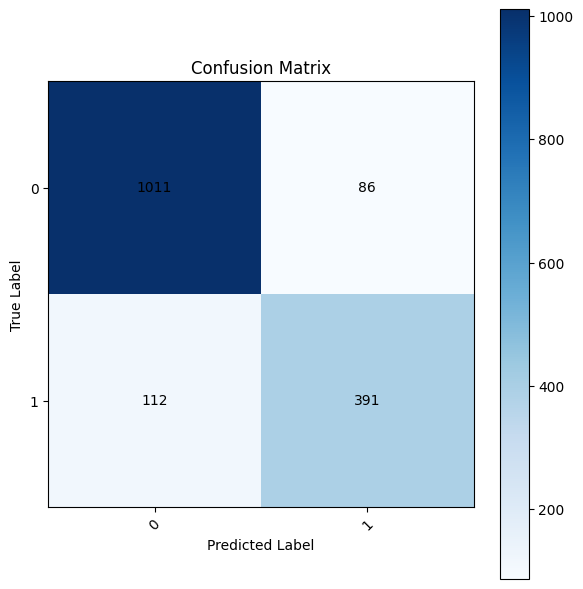

F1 Score is 87.53%


In [27]:
scaled_x, y = standardize_data(test)
nn.fit(scaled_x, y)
predicted_y = nn.predict(scaled_x)
plot_confusion_matrix(y, predicted_y)
print(f"F1 Score is {f1_score(y, predicted_y, average='weighted') * 100:.2f}%")

## Final Prediction

In [38]:
to_predict = pd.read_csv('X_test.csv').drop(columns = ['ID'])
to_predict = pre_process(to_predict)
to_predict['OUTCOME'] = '' # just so we could use the normalize function we made
x, _ = standardize_data(to_predict)

predicted_y = nn.predict(x)
carinsurance_G9_ytest = pd.DataFrame({'target': predicted_y})
carinsurance_G9_ytest.to_excel('carinsurance_G9_ytest.xlsx', index = False)
